In [811]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [812]:
m = 20          # 5, 50, 100, 500, 2000

In [813]:
train_size = 100          # 100, 500, 2000, 10000

# Generate dataset

In [814]:
np.random.seed(12)
y = np.random.randint(0,10,5000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 530
1 463
2 494
3 517
4 488
5 497
6 493
7 507
8 492
9 519


In [815]:
x = np.zeros((5000,2))

In [816]:
np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [7,4],cov=[[0.1,0],[0,0.1]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [8,6.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [5.5,6.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [-1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [0,2],cov=[[0.1,0],[0,0.1]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [0,-1],cov=[[0.1,0],[0,0.1]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [0,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [-0.5,-0.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [0.4,0.2],cov=[[0.1,0],[0,0.1]],size=sum(idx[9]))

In [817]:
x[idx[0]][0], x[idx[5]][5] 

(array([7.14957125, 3.78451422]), array([0.87756167, 0.00457805]))

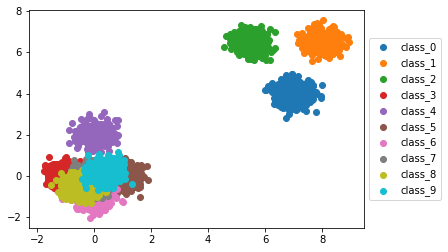

In [818]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [819]:
bg_idx = [ np.where(idx[3] == True)[0], 
          np.where(idx[4] == True)[0], 
          np.where(idx[5] == True)[0],
          np.where(idx[6] == True)[0], 
          np.where(idx[7] == True)[0], 
          np.where(idx[8] == True)[0],
          np.where(idx[9] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(3513,)

In [820]:
np.unique(bg_idx).shape

(3513,)

In [821]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [822]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([[-1.04275003e-16,  6.74571889e-17]]),
 array([[2.02981967, 1.63582644]]))

In [823]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [824]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([[1., 1.]]), array([[4.89756643, 3.00501566]]))

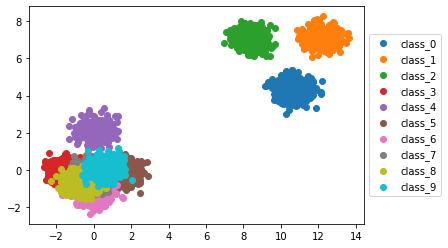

In [825]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [826]:
foreground_classes = {'class_0','class_1', 'class_2'}

background_classes = {'class_3','class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9'}

In [827]:
fg_class  = np.random.randint(0,3)
fg_idx = np.random.randint(0,m)
train_data=[]
a = []
fg_instance = np.array([[0.0,0.0]])
bg_instance = np.array([[0.0,0.0]])

for i in range(m):
  if i == fg_idx:
    b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
    fg_instance += x[b]
    a.append(x[b])
    print("foreground "+str(fg_class)+" present at " + str(fg_idx))
  else:
    bg_class = np.random.randint(3,10)
    b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
    bg_instance += x[b]
    a.append(x[b])
    print("background "+str(bg_class)+" present at " + str(i))

a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 5 present at 0
background 6 present at 1
background 9 present at 2
background 3 present at 3
background 5 present at 4
background 7 present at 5
background 6 present at 6
background 5 present at 7
background 3 present at 8
background 5 present at 9
background 4 present at 10
background 7 present at 11
background 4 present at 12
background 3 present at 13
background 9 present at 14
background 6 present at 15
background 6 present at 16
background 3 present at 17
foreground 2 present at 18
background 8 present at 19
(20, 2)
2 18


In [828]:
a

array([[ 1.52560273e+00, -1.29848805e-01],
       [-4.22650796e-01, -1.20033130e+00],
       [ 2.34349307e-01, -2.78664796e-01],
       [-9.86087689e-01, -7.51232458e-01],
       [ 1.37297554e+00, -3.76733075e-01],
       [-8.84692079e-01, -1.11551995e-01],
       [ 3.23086410e-01, -1.23774128e+00],
       [ 1.37297554e+00, -3.76733075e-01],
       [-1.37994224e+00, -1.86927689e-02],
       [ 1.18729176e+00, -1.43385686e-01],
       [ 1.08414750e+00,  2.21424613e+00],
       [ 3.07773579e-01,  5.11134472e-01],
       [-5.80062748e-01,  2.56861924e+00],
       [-1.57480355e+00,  1.37864198e-01],
       [ 8.78834768e-01, -3.18178197e-01],
       [ 5.58625839e-02, -1.37825691e+00],
       [ 3.52658712e-01, -1.71500720e+00],
       [-7.59374170e-01, -4.37189615e-03],
       [ 8.64012267e+00,  7.37468589e+00],
       [-9.53821465e-01, -7.70258879e-01]])

In [829]:
fg_instance

array([[8.64012267, 7.37468589]])

In [830]:
bg_instance

array([[ 1.15412368, -3.37912427]])

In [831]:
(fg_instance+bg_instance)/m , m

(array([[0.48971232, 0.19977808]]), 20)

In [832]:
# mosaic_list_of_images =[]
# mosaic_label = []
train_label=[]
fore_idx=[]
train_data = []
for j in range(train_size):
  np.random.seed(j)
  fg_instance = torch.zeros([2], dtype=torch.float64) #np.array([[0.0,0.0]])
  bg_instance = torch.zeros([2], dtype=torch.float64) #np.array([[0.0,0.0]])
  # a=[]

  for i in range(m):
    if i == fg_idx:
      fg_class  = np.random.randint(0,3)
      b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
      fg_instance += x[b]
      # a.append(x[b])
      # print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
      bg_class = np.random.randint(3,10)
      b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
      bg_instance += x[b]
      # a.append(x[b])
      # print("background "+str(bg_class)+" present at " + str(i))
  train_data.append((fg_instance+bg_instance)/m)
  # a = np.concatenate(a,axis=0)
  # mosaic_list_of_images.append(np.reshape(a,(2*m,1)))
  train_label.append(fg_class)
  fore_idx.append(fg_idx)

In [833]:
 train_data[0], train_label[0]

(tensor([[0.6208, 0.1138]], dtype=torch.float64), 1)

In [834]:
train_data = torch.stack(train_data, axis=0)
train_data.shape, len(train_label)

(torch.Size([100, 1, 2]), 100)

In [835]:
test_label=[]
# fore_idx=[]
test_data = []
for j in range(1000):
  np.random.seed(j)
  fg_instance = torch.zeros([2], dtype=torch.float64) #np.array([[0.0,0.0]])

  fg_class  = np.random.randint(0,3)
  b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
  fg_instance += x[b]
  # a.append(x[b])
  # print("foreground "+str(fg_class)+" present at " + str(fg_idx))

  test_data.append((fg_instance)/m)
  # a = np.concatenate(a,axis=0)
  # mosaic_list_of_images.append(np.reshape(a,(2*m,1)))
  test_label.append(fg_class)
  # fore_idx.append(fg_idx)

In [836]:
test_data[0], test_label[0]

(tensor([[0.5570, 0.1959]], dtype=torch.float64), 0)

In [837]:
test_data = torch.stack(test_data, axis=0)
test_data.shape, len(test_label)

(torch.Size([1000, 1, 2]), 1000)

In [838]:
x1 = (train_data).numpy()
y1 = np.array(train_label)

In [839]:
x1[y1==0,0]

array([[ 0.58196262, -0.06374849],
       [ 0.50819408,  0.21566994],
       [ 0.71535835,  0.05856264],
       [ 0.23393274,  0.2951525 ],
       [ 0.51849533,  0.2910084 ],
       [ 0.5746036 , -0.15526501],
       [ 0.61489395, -0.00835208],
       [ 0.18689956,  0.23054956],
       [ 0.26950646,  0.49295468],
       [ 0.67954739,  0.29959287],
       [ 0.98734141,  0.19155836],
       [ 0.56481054,  0.13539218],
       [ 0.53688243,  0.26345598],
       [ 0.63361006,  0.2008009 ],
       [ 0.61816059,  0.85652754],
       [ 0.30560728, -0.27749069],
       [ 0.59715351,  0.05521528],
       [ 0.45096462,  0.32219683],
       [ 0.3335488 ,  0.46844344],
       [ 0.53702078,  0.14843916],
       [ 0.25096454,  0.56858167],
       [ 1.0141537 ,  0.24776516],
       [ 0.48161742,  0.04829957],
       [ 0.56496278,  0.61036383],
       [ 0.68638647,  0.09156393],
       [ 0.73672883,  0.08016462],
       [ 0.49559829,  0.39001001],
       [ 0.40029358,  0.48546783],
       [ 0.72078224,

In [840]:
x1[y1==0,0][:,0]

array([0.58196262, 0.50819408, 0.71535835, 0.23393274, 0.51849533,
       0.5746036 , 0.61489395, 0.18689956, 0.26950646, 0.67954739,
       0.98734141, 0.56481054, 0.53688243, 0.63361006, 0.61816059,
       0.30560728, 0.59715351, 0.45096462, 0.3335488 , 0.53702078,
       0.25096454, 1.0141537 , 0.48161742, 0.56496278, 0.68638647,
       0.73672883, 0.49559829, 0.40029358, 0.72078224, 0.67773679])

In [841]:
x1[y1==0,0][:,1]

array([-0.06374849,  0.21566994,  0.05856264,  0.2951525 ,  0.2910084 ,
       -0.15526501, -0.00835208,  0.23054956,  0.49295468,  0.29959287,
        0.19155836,  0.13539218,  0.26345598,  0.2008009 ,  0.85652754,
       -0.27749069,  0.05521528,  0.32219683,  0.46844344,  0.14843916,
        0.56858167,  0.24776516,  0.04829957,  0.61036383,  0.09156393,
        0.08016462,  0.39001001,  0.48546783,  0.03073138,  0.48806709])

Text(0.5, 1.0, 'dataset4 CIN with alpha = 1/20')

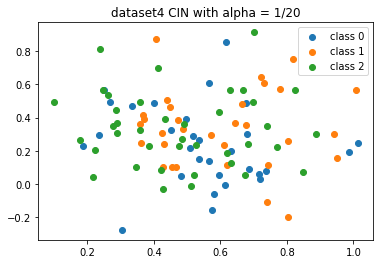

In [842]:
x1 = (train_data).numpy()
y1 = np.array(train_label)

plt.scatter(x1[y1==0,0][:,0], x1[y1==0,0][:,1], label='class 0')
plt.scatter(x1[y1==1,0][:,0], x1[y1==1,0][:,1], label='class 1')
plt.scatter(x1[y1==2,0][:,0], x1[y1==2,0][:,1], label='class 2')
plt.legend()
plt.title("dataset4 CIN with alpha = 1/"+str(m))

Text(0.5, 1.0, 'test dataset4')

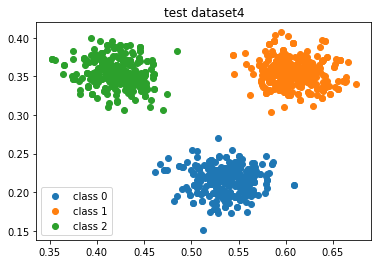

In [843]:
x1 = (test_data).numpy()
y1 = np.array(test_label)

plt.scatter(x1[y1==0,0][:,0], x1[y1==0,0][:,1], label='class 0')
plt.scatter(x1[y1==1,0][:,0], x1[y1==1,0][:,1], label='class 1')
plt.scatter(x1[y1==2,0][:,0], x1[y1==2,0][:,1], label='class 2')
plt.legend()
plt.title("test dataset4")

In [844]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [845]:
train_data[0].shape, train_data[0]

(torch.Size([1, 2]), tensor([[0.6208, 0.1138]], dtype=torch.float64))

In [846]:
batch = 200

traindata_1 = MosaicDataset(train_data, train_label )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)


In [847]:
testdata_1 = MosaicDataset(test_data, test_label )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)


In [848]:
# testdata_11 = MosaicDataset(test_dataset, labels )
# testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)

In [849]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(2,50)
        self.linear2 = nn.Linear(50,3)

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.zeros_(self.linear2.bias)

    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = (self.linear2(x))

        return x[:,0]

In [850]:
def calculate_loss(dataloader,model,criter):
  model.eval()
  r_loss = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      outputs = model(inputs)
      # print(outputs.shape)
      loss = criter(outputs, labels)
      r_loss += loss.item()
  return r_loss/(i+1)

In [851]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    pred = np.concatenate(pred, axis = 0)
    out = np.concatenate(out, axis = 0)
    print("unique out: ",  np.unique(out), "unique pred: ", np.unique(pred) )
    print("correct: ", correct, "total ",  total)
    print('Accuracy of the network on the %d test dataset %d: %.2f %%' % (total, number , 100 * correct / total))

In [852]:
def train_all(trainloader, ds_number, testloader_list, lr_list):
  
  final_loss = []
  for LR in lr_list:    
    print("--"*20, "Learning Rate used is", LR)
    
    torch.manual_seed(12)
    net = Whatnet().double()
    net = net.to("cuda")
    
    criterion_net = nn.CrossEntropyLoss()
    optimizer_net = optim.Adam(net.parameters(), lr=0.001 ) #, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 1000
    running_loss = calculate_loss(trainloader,net,criterion_net)
    loss_curi.append(running_loss)
    print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_net.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            # print(outputs.shape)
            loss = criterion_net(outputs, labels)
            # print statistics
            running_loss += loss.item()
            loss.backward()
            optimizer_net.step()

        running_loss = calculate_loss(trainloader,net,criterion_net)
        if(epoch%200 == 0):
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
        loss_curi.append(running_loss)   #loss per epoch
        if running_loss<=0.05:
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss))
          break

    print('Finished Training')
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d train images: %.2f %%' % (total,  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    final_loss.append(loss_curi) 
  return final_loss
    

In [853]:
train_loss_all=[]

testloader_list= [ testloader_1]
lr_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5 ]

In [854]:
fin_loss = train_all(trainloader_1, 1, testloader_list, lr_list)
train_loss_all.append(fin_loss)

---------------------------------------- Learning Rate used is 0.0001
epoch: [0 ] loss: 1.097
epoch: [1] loss: 1.096
epoch: [201] loss: 1.037
epoch: [401] loss: 1.024
epoch: [601] loss: 1.011
epoch: [801] loss: 0.999
Finished Training
Accuracy of the network on the 100 train images: 45.00 %
unique out:  [0 1 2] unique pred:  [1 2]
correct:  686 total  1000
Accuracy of the network on the 1000 test dataset 1: 68.60 %
--------------------------------------------------------------------------------
---------------------------------------- Learning Rate used is 0.0005
epoch: [0 ] loss: 1.097
epoch: [1] loss: 1.096
epoch: [201] loss: 1.037
epoch: [401] loss: 1.024
epoch: [601] loss: 1.011
epoch: [801] loss: 0.999
Finished Training
Accuracy of the network on the 100 train images: 45.00 %
unique out:  [0 1 2] unique pred:  [1 2]
correct:  686 total  1000
Accuracy of the network on the 1000 test dataset 1: 68.60 %
--------------------------------------------------------------------------------


In [855]:
%matplotlib inline

In [856]:
len(fin_loss)

8

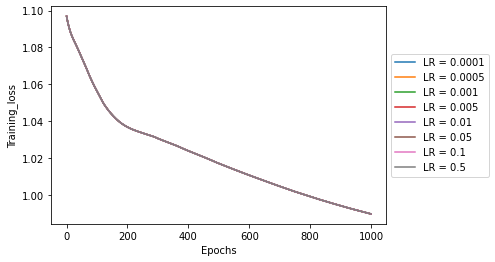

In [857]:
for i,j in enumerate(fin_loss):
    plt.plot(j,label ="LR = "+str(lr_list[i]))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))